# Imports

In [376]:
from collections import namedtuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm

ModuleNotFoundError: No module named 'tqdm'

# GridViewer Environment

The environment manages a wrap-around 2D grid of cells, a zoom camera and a cursor in camera coordinates. In each timestep, there is the opportunity to move the cursor (for the user to hover over a cell of interest) and to move the camera (for the assistant to support the user's goal).

Currently, both cursor and camera movement are restricted to shifts along x.

In [246]:
Size = namedtuple('Size', 'w h')
Point = namedtuple('Point', 'x y')
Rect = namedtuple('Rect', 'xy w h') # xy is of type Point
Cell = namedtuple('Cell', 'xy w h c') #c is color

class GridViewer:
    
    """
    Interface showing a cropped view onto a grid where cells could represent,
    for example, local regions on a map or buttons as on a keyboard.
    
    A shift-zoom camera shows a translated version of the grid with, depending
    on the zoom level, only a subset of cells visible or cells appearing in
    multiple locations wrapping the grid around along both x and y axes.
    """
    
    State = namedtuple('State', 'camera cells cursor grid_size hovered_cell visible_cells')
    
    def __init__(self, grid_size, n_cells, camera_0, cursor_0):
        """
        grid_size (Size): width and height of the world in world coordinates
        n_cells (Point): number of cells in x and y direction
        camera_0 (Rect): initial aperture settings after reset.
        cursor_0 (Point): x, y coordinates of cursor in aperture view coordinates.
        """
        
        self.grid_size = grid_size
        self.n_cells = n_cells
        self.camera_0 = camera_0
        self.cursor_0 = self._clipped_cursor(cursor_0, self.camera_0)
        self.user = user
        self.cells = self.init_cells(self.grid_size, self.n_cells)
        
    @staticmethod
    def init_cells(grid_size, n_cells):
        w, h = grid_size.w / n_cells.x, grid_size.h / n_cells.y
        cmap = mpl.colormaps['viridis'].resampled(n_cells.x * n_cells.y)
        # (xy-bottom left, width, height, color)
        cells = []
        for ix in range(n_cells.x):
            for iy in range(n_cells.y):
                cells.append(Cell(Point(x=ix*w, y=iy*h), 
                                  w=w, h=h, c=cmap(iy*n_cells.x + ix)))

        return cells
    
    def reset(self):
        visible_cells = self._cells_in_camera_view(self.cells, 
                                                   self.camera_0, 
                                                   self.grid_size)
        hovered_cell = self._hovered_cell(self.camera_0, 
                                          self.cells, 
                                          self.cursor_0, 
                                          self.grid_size)
        self.s_t = self.State(camera=self.camera_0, 
                              cells=self.cells,
                              cursor=self.cursor_0, 
                              grid_size=self.grid_size,
                              hovered_cell=hovered_cell,
                              visible_cells=visible_cells)
        return self.s_t
    
    @staticmethod
    def _cells_in_camera_view(cells, camera, grid_size):
        a_x0, a_x1 = camera.xy.x, camera.xy.x + camera.w
        a_y0, a_y1 = camera.xy.y, camera.xy.y + camera.h

        def clipped_cell(cell, filter_height=True):
            x0, x1 = cell.xy.x, cell.xy.x + cell.w
            y0, y1 = cell.xy.y, cell.xy.y + cell.h
            x0_clip, x1_clip = np.clip([x0, x1], a_x0, a_x1)
            y0_clip, y1_clip = np.clip([y0, y1], a_y0, a_y1)
            w_clip, h_clip = x1_clip - x0_clip, y1_clip - y0_clip
            
            if w_clip > 0 and (not filter_height or h_clip > 0):
                cell1 = Cell(xy=Point(x=x0_clip-a_x0,y=y0_clip-a_y0), 
                             w=w_clip, h=h_clip, c=cell.c)
                return [cell1]
            
            return []

        visible_cells = []
        for cell in cells:
            cell_i = cell._replace()
            copies = []
            x_copies = clipped_cell(cell_i, filter_height=False)
            # repeat tiles along x
            while True:
                
                cell_i = cell._replace(xy=cell.xy._replace(x=cell_i.xy.x + grid_size.w))
                x_copies_i = clipped_cell(cell_i, filter_height=False)
                if len(x_copies_i) == 0:
                    break

                x_copies.extend(x_copies_i)

            if len(x_copies) > 0 and x_copies[0].h > 0:
                # add cells along x to visible cells if they are visible
                copies.extend(x_copies)
            
            # repeat subtiles along y
            for cell_x in x_copies:
                y_copies = []
                cell_i = cell_x._replace(xy=cell_x.xy._replace(y=cell.xy.y))
                while True:
                    
                    cell_i = cell_i._replace(xy=cell_i.xy._replace(y=cell_i.xy.y + grid_size.h))
                    y_copies_i = clipped_cell(cell_i)
                    if len(y_copies_i) == 0:
                        break
                        
                    y_copies.exptend(y_copies_i)
                copies.extend(y_copies)
            visible_cells.append(copies)
        return visible_cells

    @classmethod
    def transition_assistant(cls, s, a):
        cam = s.camera
        cam1 = Rect(Point(x=a*s.grid_size.w, y=cam.xy.y), w=cam.w, h=cam.h)
        cam1 = cls._clipped_camera(cam1, s.grid_size)
        cursor1 = cls._clipped_cursor(cursor=s.cursor, camera=cam1)
        visible_cells1 = cls._cells_in_camera_view(s.cells, cam1, s.grid_size)
        hovered_cell1 = cls._hovered_cell(cam1, s.cells, cursor1, s.grid_size)
        return s._replace(camera=cam1, 
                          cursor=cursor1, 
                          hovered_cell=hovered_cell1,
                          visible_cells=visible_cells1)
        
    @staticmethod
    def _clipped_camera(camera, grid_size):
        # restrict xy to map limits
        xy = Point(x=np.clip(camera.xy.x, 0, grid_size.w),
                   y=np.clip(camera.xy.y, 0, grid_size.h))
        return camera._replace(xy=xy)
    
    @staticmethod
    def _clipped_cursor(cursor, camera):
        # restrict xy to camera limits
        return Point(x=np.clip(cursor.x, 0, camera.w),
                     y=np.clip(cursor.y, 0, camera.h))
        
    def step_assistant(self, a):
        """
        Executes the action of an assistant. Here, the action represents
        the new normalized camera shift along x.
        
        Args
        ----
        a (float): normalized absolute camera x-shift in [0, 1].
        
        Returns
        -------
        state (State): grid viewer state after adjusting the camera parameters.
        """
        
        self.s_t = self.transition_assistant(s=self.s_t, a=a)
        return self.s_t
    
    @classmethod
    def transition_user(cls, s, a):
        # compute successor state after user takes action a in state s
        cursor1 = Point(x=s.cursor.x + a, y=s.cursor.y)
        cursor1 = cls._clipped_cursor(cursor1, s.camera)
        hovered_cell1 = cls._hovered_cell(s.camera, s.cells, cursor1, s.grid_size)
        return s._replace(cursor=cursor1, hovered_cell=hovered_cell1)
        
    def step_user(self, a):
        """
        Executes an action on the cursor (performed by the user), which 
        represents a shift in cursor position along the x axes.
        
        Args
        ----
        a (float): intended cursor shift from latest position
        
        Returns
        -------
        state (State): grid viewer state after adjusting cursor position.
        """
        
        self.s_t = self.transition_user(s=self.s_t, a=a)
        return self.s_t
    
    @classmethod
    def render_world_view(cls, s, ax=None):
        cursor = cls._absolute_cursor(s.cursor, s.camera, s.grid_size)
        
        if ax is None:
            fig, ax = plt.subplots()
            
        ax.set_title('World View')
        ax.set_xlim([0., np.maximum(s.grid_size.w, s.camera.xy.x + s.camera.w)])
        ax.set_ylim([0., np.maximum(s.grid_size.h, s.camera.xy.y + s.camera.h)])
            
        # draw cells
        for c in s.cells:
            ax.add_patch(mpl.patches.Rectangle(c.xy, c.w, c.h, color=c.c))
            
        # draw grid outline
        ax.add_patch(mpl.patches.Rectangle([0, 0], s.grid_size.w, s.grid_size.h, 
                                           fill=False,
                                           edgecolor='blue', 
                                           linewidth=2., 
                                           label='grid outline'))
        # draw camera
        ax.add_patch(mpl.patches.Rectangle(s.camera.xy, s.camera.w, s.camera.h, 
                                           fill=False,
                                           edgecolor='red', 
                                           linewidth=2., 
                                           label='camera'))
            
        # draw cursor
        ax.scatter(x=cursor.x, y=cursor.y, marker='x', s=10**2, color='red', 
                   linewidth=2, label='cursor')
        ax.legend()
        
    @staticmethod
    def render_camera_view(s, ax=None):
        if ax is None:
            fig, ax = plt.subplots()

        ax.set_title('Camera View')
        ax.set_xlim([0., s.camera.w])
        ax.set_ylim([0., s.camera.h])
        for cell in s.visible_cells:
            # iterate over cell parts/ copies
            for c in cell:
                ax.add_patch(mpl.patches.Rectangle(c.xy, c.w, c.h, 
                                                   facecolor=c.c, 
                                                   edgecolor='white'))
                
        # draw cursor
        ax.scatter(x=s.cursor.x, y=s.cursor.y, marker='x', s=10**2, color='red', 
                   linewidth=2, label='cursor')
        ax.legend()
    
    @staticmethod
    def _absolute_cursor(cursor, camera, grid_size):
        return Point(x = (cursor.x + camera.xy.x) % grid_size.w,
                     y = (cursor.y + camera.xy.y) % grid_size.h)
    
    @classmethod
    def _hovered_cell(cls, camera, cells, cursor, grid_size):
        # determine the tile the cursor currently hovers over
        cursor = cls._absolute_cursor(cursor, camera, grid_size)
        for i in range(len(cells)):
            c = cells[i]
            if cursor.x >= c.xy.x and cursor.y >= c.xy.y and \
               cursor.x < c.xy.x + c.w and cursor.y < c.xy.y + c.h:
                return i
            
        return None

camera: Point(x=0, y=0) cursor: Point(x=400.0, y=300.0) grid_size Size(w=800, h=600)
camera: Point(x=200.0, y=0) cursor: Point(x=400.0, y=300.0) grid_size Size(w=800, h=600)


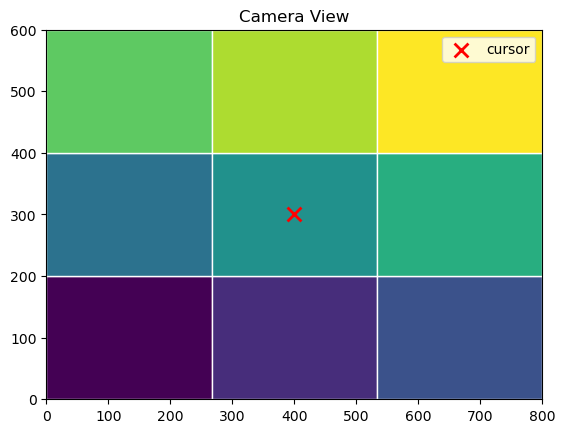

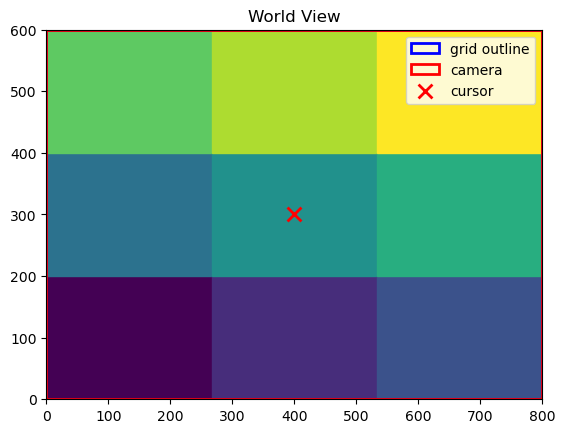

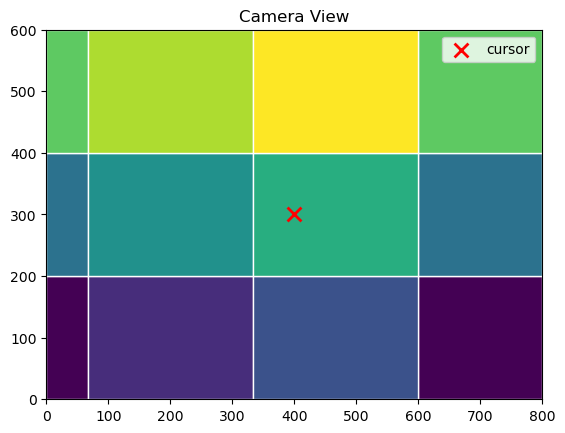

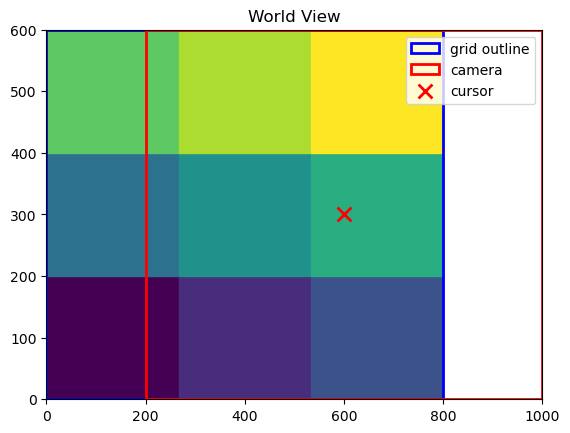

In [247]:
grid_size = Size(w=800, h=600)
n_cells = Point(x=3, y=3)
camera = Rect(xy=Point(x=0, y=0), w=grid_size.w, h=grid_size.h)
cursor = Point(x=camera.w*0.5, y=camera.h*0.5)

env = GridViewer(grid_size=grid_size, n_cells=n_cells, camera_0=camera, cursor_0=cursor)
s = env.reset()
print('camera:', s.camera.xy, 'cursor:', s.cursor, 'grid_size', s.grid_size)
env.render_camera_view(s)
env.render_world_view(s)
s = env.step_assistant(a=0.25)
s = env.step_user(a=0)
print('camera:', s.camera.xy, 'cursor:', s.cursor, 'grid_size', s.grid_size)
env.render_camera_view(s)
env.render_world_view(s)

# User Model

The user model has the desire to hover the cursor over a target cell, correctly identifies the direction of movement for the cursor to get there, and takes a fixed length step plus some noise along that direction.

In [241]:
import numpy as np
from scipy.stats import norm

class Fish:
    
    def __init__(self, 
                 n_targets, # total number of available targets
                 goal, # user goal
                 step_size, # amount of cursor movement (in aperture coordinates)
                 sigma): # amount of Gaussian noise around movement
        self.n_targets = n_targets
        self.goal = goal % n_targets
        self.step_size = step_size
        self.sigma = sigma
        
    def reset(self):
        return 0 # do nothing before first observation
        
    def step(self, s):
        # compute likelihood
        p_a = self._p_a_given_s_and_goal(s, self.goal)
        a = p_a.rvs() # sample
        return a
    
    def _p_a_given_s_and_goal(self, s, i):
        # likelihood of action given environment state and use goal
        mean = 0
        if not (s.hovered_cell == i):
            # the below approach estimates the shortest distance to the edge,
            # which is assumed to be perpendicular to the direction of travel.
            # if this is not the case we need a different method, i.e. when
            # we move to 2D cursor movement this does not generalise
            
            # estimate shortest (signed) distance to edge of goal tiles along x
            a_x = [[c.xy.x - s.cursor.x, c.xy.x+c.w - s.cursor.x] for c in s.visible_cells[i]]
            a_x = np.array(a_x)
            a_x = np.array([a_x[i, min_j] for i, min_j in zip(range(a_x.shape[0]), np.argmin(np.abs(a_x), axis=1))])
            
            # estimate shortest (signed) distance to edge of goal tiles along y
            #a_y = [[c.xy.y - s.cursor.y, c.xy.y+c.h - s.cursor.y] for c in s.visible_cells[i]]
            #a_y = np.array(a_y)
            #a_y = np.array([a_y[i, min_j] for i, min_j in zip(range(a_y.shape[0]), np.argmin(np.abs(a_y), axis=1))])
            
            # currently, action is only along x, so we ignore y for the distance
            d = np.abs(a_x) # np.sqrt(a_x**2 + a_y**2)
            
            # ideal action
            #action = np.array([a_x[np.argmin(d)], a_y[np.argmin(d)]])/d * self.step_size
            mean = a_x[np.argmin(d)]
            
            # discretized action
            # TODO: normalize vector to step_size length in 2D
            mean = np.sign(mean) * self.step_size
            
        return norm(loc=mean, scale=self.sigma)
    
    def p_o_given_s(self, s_env):
        # returns a list of likelihoods p(a|s, s_env): [s]
        return np.array([self._p_a_given_s_and_goal(s_env, i) for i in range(self.n_targets)])


## User interaction with the GridViewer environmnet

Let's simulate the interaction between the user and the environment. Below, we illustrate the movement of the cursor in world coordinates over time. We add some jitter along y to better illustrate _backwards_ steps that may occur depending on the amount of noise the user adds to the optimal action.

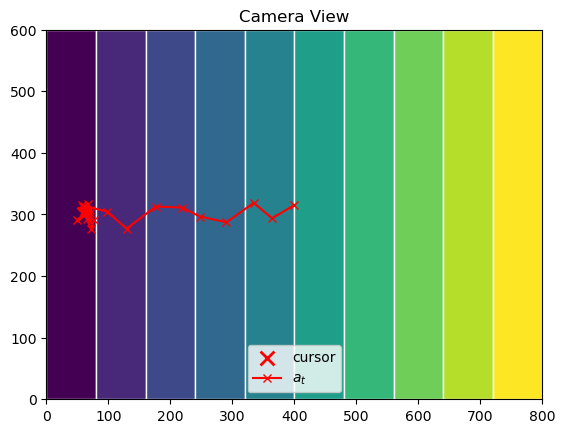

In [248]:
grid_size = Size(w=800, h=600)
n_cells = Point(x=10, y=1)
camera = Rect(xy=Point(x=0, y=0), w=grid_size.w, h=grid_size.h)
cursor = Point(x=camera.w*0.5, y=camera.h*0.5)

user = Fish(n_targets=n_cells.x*n_cells.y, 
            goal=0, 
            step_size = int(camera.w*0.05), 
            sigma=1e1)
user.reset()

env = GridViewer(grid_size=grid_size, n_cells=n_cells, camera_0=camera, cursor_0=cursor)

ss = []
aa_user = []
ss.append(env.reset())

for i in range(20):
    
    #env.render_camera_view(ss[-1])
    #env.render_world_view(s)
    aa_user.append(user.step(ss[-1]))
    ss.append(env.step_user(aa_user[-1]))
    
env.render_camera_view(ss[-1])
#plt.subplots()
cursor_t = np.array([s.cursor.x for s in ss])
plt.plot(cursor_t, env.s_t.cursor.y + 50*(np.random.uniform(size=cursor_t.shape)-0.5), 'r-x', label='$a_t$', zorder=100)
plt.legend()

# Active Inference assistant

An assistant that reasons about the user's hidden goal and adjusts the camera to support the user has the following properties:

- the unobserved state space represents the **discrete** set of goals (target cells) of the user
- the observed state space represents the state of the GridViewer, which has discrete and continuous elements
- the observations generated by the unobserved state represent the user's actions and are **continuous**
- the assistant's actions represent a shift of the camera as a **continuous** proportion of $[0, 1]$ the grid size along x.

We develop the active inference agent for this problem starting with the `ContinuousAOAgent` developed in notebook 04. 

#### Markov Blanket
The environment of the assistant now consists of the grid viewer and the user. It observes the user's actions and the grid viewer's state, reasons about the user's beliefs and selects actions that indirectly affect the user by modifying the camera position of the grid viewer. The assistant needs models of both to reason about this three-way interaction, update its belief about the user's goal and to select a supportive action.

#### Belief update through time

The goal of the user is assumed to be fixed in this scenario. It follows that the assistants actions do not change the unobserved state it reasons about, so that the assistants belief about the user's goal does not need updating in response to the assistants actions.

#### Belief update after new observation

The belief update after a new observation from the user involves evaluating the likelihood $p(o|s_{user}, s_{env})$ for all hypothetical discrete goals the user may have $s_{user}$ conditiond on the grid viewer state $s_{env}$. This requires 

#### Assistant Preference

So far, we represented the assistants preference in variants of the minimal environment as a preference over environment states. Here we move away from that and develop a notion of preference that represents the assistants objective of supporting the user in reaching their (unobserved) goal. Intuitively, we want to evaluate how compatible the assistant's actions and user's goal are. In this scenario, the user's goal is for the cursor to hover over one particular cell $i$. If we knew the user's goal, we could define $p_c(s_{env})$ as the probability distribution over environment states $s_{env}$ that is zero in all states in which the cursor doesn't over over cell $i$ and one in those states that do.

$\mathbb{E}_{Q_{env}(s_{env}^{t+1}|s_{env}^{t}, a_a^t)}\left[ \ln p_c(\text{cell}(s_{env}^t)) \right] \quad = \quad \ln p_c(\text{cell}(s_{env}^t)) \quad \approx \quad \ln Q_{usr}(\text{cell}(s_{env}^t))$,

where we made use of the knowledge that the environment state is fully observed and its transition dynamics are deterministic. While we don't know the user's goal $i$, we have a belief about it represented as  $Q_{usr}(s_{usr})$. We use this to approximate $p_c$ by spreading the probability mass over goals in proportion to our belief that each goal is held by the user.



#### Summary of changes to the agent implementation

- replace the model of the environment with a model of the interface and a model of the user
- remove the explicit representation of a target state
- remove belief updating in response to the agent's actions
- update environment state after belief updating and before action selection in the step function
- hardcode limits of assistant action to [0, 1]. Move this into the grid viewer in the future.
- update pragmatic value estimation to assistant's notion of preference.

#### Summary of changes to the user model

- a method taking $s_{env}$ as parameter and returning $p(o|s_{usr}, s_{env})$ as a list of likelihoods for each hypothetical user goal.

#### TODO

- move limits to assistant actions into GridViewer and add limits to user actions there, too.

In [370]:
import numpy as np
import torch

def softmax(x):
  e = np.exp(x - x.max())
  return e / e.sum()

def kl(a, b):
    """ Discrete KL-divergence """
    return (a * (np.log(a) - np.log(b))).sum()

class ContinuousAOAssistant:
    
    def __init__(self, 
                 env_model,
                 user_model,
                 n_plans=128, # number of plans rolled out during action selection
                 k=2, # planning horizon
                 n_o_samples=10, # observation samples for information gain
                 use_info_gain=True, # score actions by info gain
                 use_pragmatic_value=True, # score actions by pragmatic value
                 select_max_pi=True, # sample plan (False), select max negEFE (True).
                 n_steps_o=20, # optimization steps after new observation
                 lr_o=4.): # learning rate of optimization after new observation
        
        self.env_model = env_model
        self.user_model = user_model
        self.n_plans = n_plans
        self.k = k
        self.n_o_samples = n_o_samples
        self.use_info_gain = use_info_gain
        self.use_pragmatic_value = use_pragmatic_value
        self.select_max_pi = select_max_pi
        self.n_steps_o = n_steps_o
        self.lr_o = lr_o
        
    def reset(self):
        # initialize state prior as uniform
        self.b = np.zeros(self.user_model.n_targets)
        # in the absence of prior knowledge, initialise camera at 0
        return 0
        
    def step(self, o_env, o_user, debug=False):
        if debug:
            return self._step_debug(o_env, o_user)
        
        self.b = self._update_belief(theta_prev=self.b, 
                                     o_env=o_env, 
                                     o_user=o_user)
        # model next environment state after user action
        o_env1 = self.env_model.transition_user(s=o_env, a=o_user)
        a = select_action(theta_start=self.b, o_env=o_env1)[0] # pop first action of selected plan
        return a
    
    def _step_debug(self, o_env, o_user):
        self.b, ll_o = self._update_belief(theta_prev=self.b, 
                                           o_env=o_env, 
                                           o_user=o_user, 
                                           debug=True)
        # model next environment state after user action
        o_env1 = self.env_model.transition_user(s=o_env, a=o_user)
        a, plans, p_pi, _ = self._select_action(theta_start=self.b, o_env=o_env1, debug=True)
        max_a = plans[np.argmax(p_pi)][0]
        a = a[0]
        return a, ll_o, max_a
    
    def _update_belief(self, theta_prev, o_env, o_user, debug=False):
        theta = torch.tensor(theta_prev)

        # make p(s) from b
        q = torch.nn.Softmax(dim=0)
        p_o_given_s = [p.pdf(o_user) for p in self.user_model.p_o_given_s(o_env)]
        p_o_given_s = torch.tensor(p_o_given_s)
        p = p_o_given_s * q(theta) # p(o|s)p(s)
        log_p = torch.log(p)

        # initialize updated belief with current belief
        theta1 = torch.tensor(theta_prev, requires_grad=True)

        # estimate loss
        def forward():
            q1 = q(theta1)
            # free energy: KL[ q(s) || p(s, o) ]
            fe = torch.sum(q1 * (torch.log(q1) - log_p))
            return fe

        optimizer = torch.optim.SGD([theta1], lr=self.lr_o)
        ll = np.zeros(self.n_steps_o)
        for i in range(self.n_steps_o):
            l = forward()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            if debug:
                ll[i] = l.detach().numpy()

        theta1 = theta1.detach().numpy()
        if debug:
            return theta1, ll

        return theta1

    def _select_action(self, theta_start, o_env, debug=False): 
        # return plans, p of selecting each, and marginal p of actions
        
        # sampling
        a_lims = [0, 1]
        plans = np.random.uniform(low=a_lims[0], high=a_lims[1], size=(self.n_plans, self.k)).tolist()
        
        # evaluate negative expected free energy of all plans
        nefes = []
        info_gains = []
        for pi in plans:
          
          if debug:
            step_nefes, info_gain = self._rollout_step(theta_start, o_env, pi, 
                                                        debug=True)
            info_gains.append(info_gain)
          else:
            step_nefes = self._rollout_step(theta_start, o_env, pi)
            
          nefe = np.array(step_nefes).mean() # expected value over steps
          nefes.append(nefe)

        # compute probability of following each plan
        p_pi = softmax(np.array(nefes)).tolist()
        if self.select_max_pi:
            a = plans[np.argmax(nefes)]
        else:
            a = plans[np.random.choice(len(plans), p=p_pi)]

        if debug:
            return a, plans, p_pi, info_gains

        return a
      
    def _rollout_step(self, theta, o_env, pi, debug=False):
        if pi == []:
            return []

        a, pi_rest = pi[0], pi[1:]
        # Where will I be after taking action a?
        s_env1 = self.env_model.transition_assistant(s=o_env, a=a)
        
        # Do I like being there?
        q = softmax(theta) # current belief (where user wants to go)
        # cursor after action a is at s_env1.hovered_cell
        # is the outcome of the action consistent with user goals?
        pragmatic = np.log(q)[s_env1.hovered_cell]
        
        # What might I observe after taking action a? (marginalize p(o, s) over s)
        ss_user = np.random.choice(range(self.user_model.n_targets), p=q, size=self.n_o_samples)
        oo_user = [rv.rvs() for rv in self.user_model.p_o_given_s(s_env1)[ss_user]]
        # Do I learn about s_user from observing o_user?
        q_o = [softmax(self._update_belief(theta, o_env=s_env1, o_user=o)) for o in oo_user]
        d_o = [kl(q_o_i, q) for q_o_i in q_o] # info gain for each observation
        info_gain = np.mean(d_o) # expected value of info gain
        # negative expected free energy for this timestep
        nefe = self.use_pragmatic_value * pragmatic + \
               self.use_info_gain * info_gain
        
        # nefe for remainder of policy rollout
        # advance environment by taking one user action
        s_env2 = self.env_model.transition_user(s=s_env1, a=oo_user[0])
        nefe_rest = self._rollout_step(theta, s_env2, pi_rest)
        # concatenate expected free energy across future time steps
        if debug:
          return [nefe] + nefe_rest, info_gain

        return [nefe] + nefe_rest

## Reasoning about user goals

Let's simulate an interaction between the grid viewer and the user with the assistant simply observing the interaction and reasoning about the user's goals.

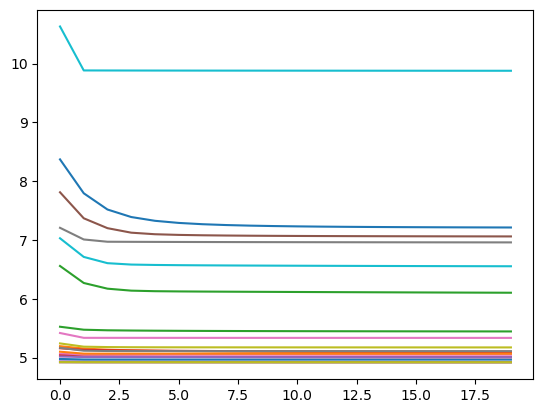

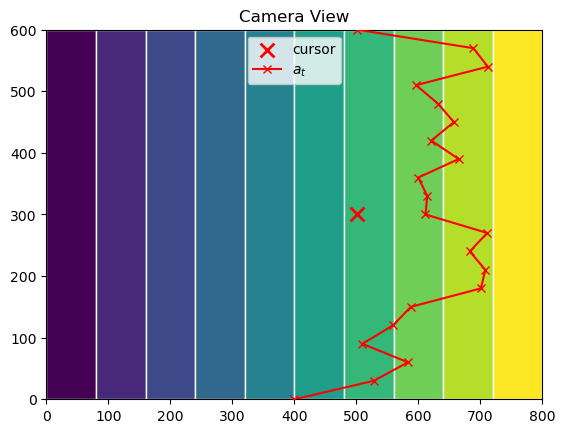

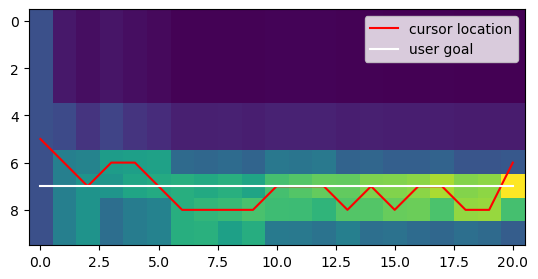

In [371]:
grid_size = Size(w=800, h=600)
n_cells = Point(x=10, y=1)
camera = Rect(xy=Point(x=0, y=0), w=grid_size.w, h=grid_size.h)
cursor = Point(x=camera.w*0.5, y=camera.h*0.5)

user = Fish(n_targets=n_cells.x*n_cells.y, 
            goal=7, 
            step_size = int(camera.w*0.05), 
            sigma=5e1)
user.reset()

env = GridViewer(grid_size=grid_size, n_cells=n_cells, camera_0=camera, cursor_0=cursor)

assistant = ContinuousAOAssistant(env_model=env, 
                                  user_model=user, 
                                  n_steps_o=20,
                                  lr_o=2e0)
assistant.reset()

ss = [env.reset()]
aa_user = []
bb = [assistant.b]

fig, ax = plt.subplots() # plot belief update loss curves
for i in range(20):
    aa_user.append(user.step(ss[-1]))
    b, ll_o = assistant._update_belief(theta_prev=assistant.b, 
                                 o_env=ss[-1], 
                                 o_user=aa_user[-1], debug=True)
    assistant.b = b
    plt.plot(ll_o)
    bb.append(b)
    ss.append(env.step_user(aa_user[-1]))
    
env.render_camera_view(ss[-1])
cursor_t = np.array([s.cursor.x for s in ss])
plt.plot(cursor_t, np.linspace(0,1,num=cursor_t.shape[0])*grid_size.h, 'r-x', label='$a_t$', zorder=100)
plt.legend()

fig, ax = plt.subplots()
plt.imshow(np.array(bb).T)
plt.plot([s.hovered_cell for s in ss], 'r-', label='cursor location')
plt.plot([user.goal for s in ss], 'white', label='user goal')
plt.legend()

## Acting

Text(0.5, 1.0, 'information gain')

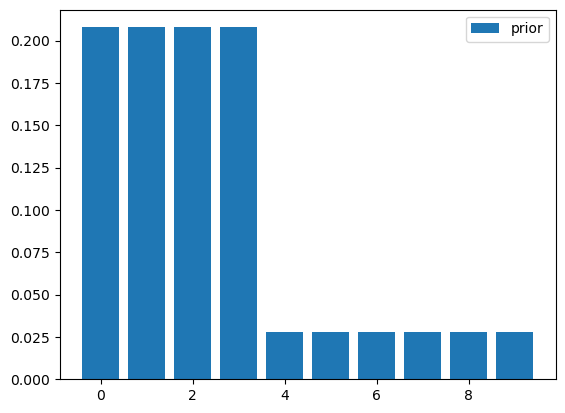

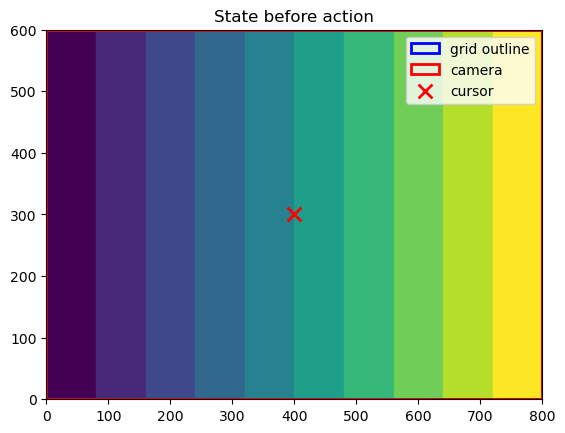

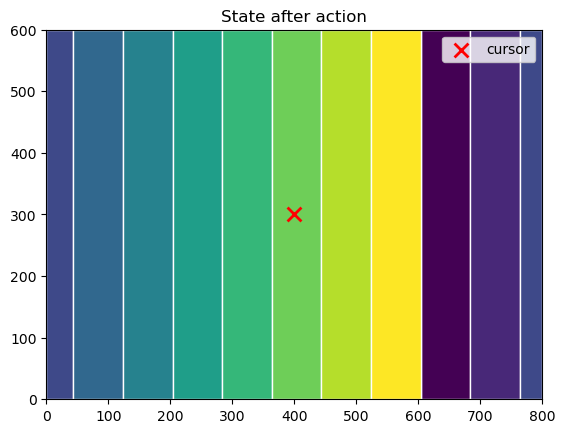

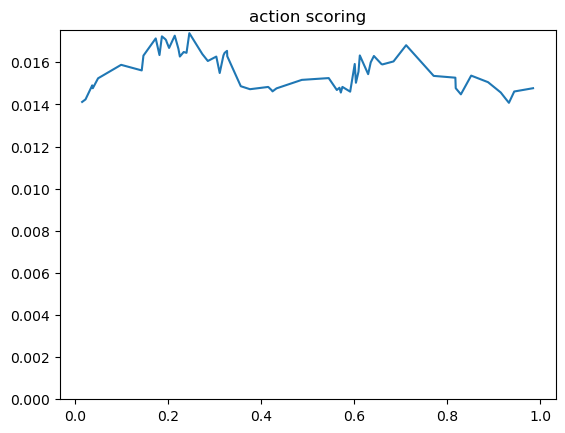

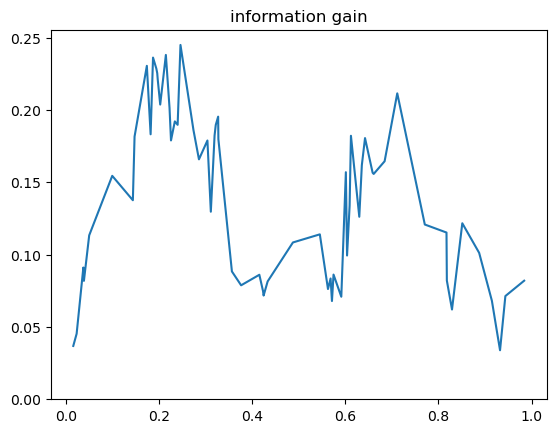

In [372]:
# lets explore which action the assistant selects given an environment state and a user action

grid_size = Size(w=800, h=600)
n_cells = Point(x=10, y=1)
camera = Rect(xy=Point(x=0, y=0), w=grid_size.w, h=grid_size.h)
cursor = Point(x=camera.w*0.5, y=camera.h*0.5)

user = Fish(n_targets=n_cells.x*n_cells.y, 
            goal=7, 
            step_size = int(camera.w*0.05), 
            sigma=5e1)
user.reset()
env = GridViewer(grid_size=grid_size, n_cells=n_cells, camera_0=camera, cursor_0=cursor)
assistant = ContinuousAOAssistant(env_model=env, 
                                  user_model=user,
                                  use_pragmatic_value=False,
                                  use_info_gain=True,
                                  n_plans=64,
                                  k=1,
                                  n_o_samples=64, # observation samples for information gain
                                  n_steps_o=10,
                                  lr_o=2e0)

s = env.reset()
#env.render_world_view(s)

user_action = 100.
theta = np.eye(user.n_targets)[0] * 2 + \
        np.eye(user.n_targets)[1] * 2 + \
        np.eye(user.n_targets)[2] * 2 + \
        np.eye(user.n_targets)[3] * 2

plt.subplots()
plt.bar(range(user.n_targets), height=softmax(theta), label='prior')
plt.legend()
a, plans, p_pi, info_gains = assistant._select_action(theta_start=theta, o_env=s, debug=True)
s1 = env.step_assistant(a=a[0])
env.render_world_view(s)
plt.title('State before action')
env.render_camera_view(s1)
plt.title('State after action')

plt.subplots()
aa = np.array([pi[0] for pi in plans])
idx = np.argsort(aa)
aa = aa[idx]
p = np.array(p_pi)[idx]
plt.plot(aa, p)
ylim = plt.ylim()
plt.ylim([0, ylim[1]])
plt.title('action scoring')

plt.subplots()
aa = np.array([pi[0] for pi in plans])
idx = np.argsort(aa)
aa = aa[idx]
ig = np.array(info_gains)[idx]
plt.plot(aa, ig)
ylim = plt.ylim()
plt.ylim([0, ylim[1]])
plt.title('information gain')

0 assistant 0.9281741012907985
1 assistant 0.9578839377022617
2 assistant 0.8670929068398368
3 assistant 0.43206326018210195
4 assistant 0.09046911201485341
5 assistant 0.13439497071712225
6 assistant 0.09364426886962762
7 assistant 0.32827996704072626
8 assistant 0.35953116154733555
9 assistant 0.30412172057357545
10 assistant 0.39941097000420245
11 assistant 0.3920857174112511
12 assistant 0.5127932316919377
13 assistant 0.47253788398964747
14 assistant 0.43545133248390566
15 assistant 0.44933967571340605
16 assistant 0.40635015994005663
17 assistant 0.3901726978750736
18 assistant 0.4127678177721483
19 assistant 0.3109892429248656
20 assistant 0.3304573215545066
21 assistant 0.375652804427707
22 assistant 0.4017027244398692
23 assistant 0.2809840388057614
24 assistant 0.3234529357028033
25 assistant 0.16305945140634037
26 assistant 0.10970554456913828
27 assistant 0.051935586856293514
28 assistant 0.10987932690126923
29 assistant 0.14371248381424728
30 assistant 0.0882076361328995
3

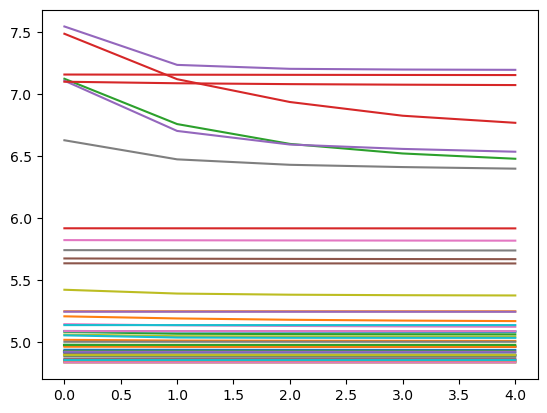

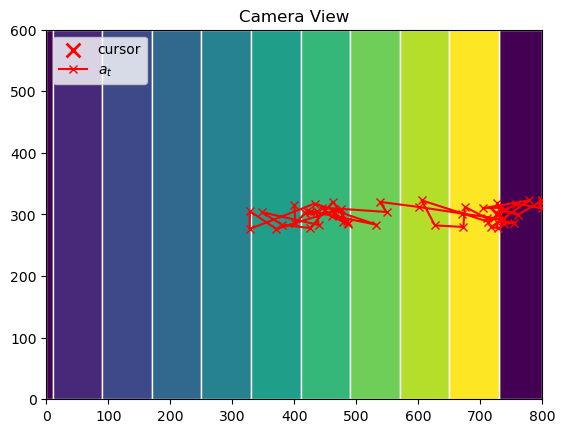

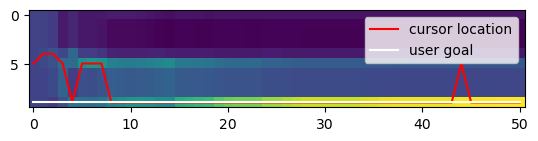

In [375]:
grid_size = Size(w=800, h=600)
n_cells = Point(x=10, y=1)
camera = Rect(xy=Point(x=0, y=0), w=grid_size.w, h=grid_size.h)
cursor = Point(x=camera.w*0.5, y=camera.h*0.5)

user = Fish(n_targets=n_cells.x*n_cells.y, 
            goal=9, 
            step_size = int(camera.w*0.05), 
            sigma=5e1)
user.reset()

env = GridViewer(grid_size=grid_size, n_cells=n_cells, camera_0=camera, cursor_0=cursor)
assistant = ContinuousAOAssistant(env_model=env, 
                                  user_model=user, 
                                  n_plans=32,
                                  k=1,
                                  n_steps_o=5,
                                  lr_o=2e0)
assistant.reset()

ss = [env.reset()]
aa_user = []
aa_assistant = []
bb = [assistant.b]

fig, ax = plt.subplots() # plot belief update loss curves
for i in range(50):
    aa_user.append(user.step(ss[-1]))
    a_assistant, ll_o, max_a = assistant.step(o_env=ss[-1], 
                                              o_user=aa_user[-1], 
                                              debug=True)
    print(i, 'assistant', a_assistant)
    plt.plot(ll_o)
    bb.append(assistant.b)
    aa_assistant.append(a_assistant)
    env.step_user(aa_user[-1])
    ss.append(env.step_assistant(aa_assistant[-1]))
    
env.render_camera_view(ss[-1])
cursor_t = np.array([s.cursor.x for s in ss])
plt.plot(cursor_t, env.s_t.cursor.y + 50*(np.random.uniform(size=cursor_t.shape)-0.5), 'r-x', label='$a_t$', zorder=100)
plt.legend()

fig, ax = plt.subplots()
plt.imshow(np.array(bb).T)
plt.plot([s.hovered_cell for s in ss], 'r-', label='cursor location')
plt.plot([user.goal for s in ss], 'white', label='user goal')
plt.legend()

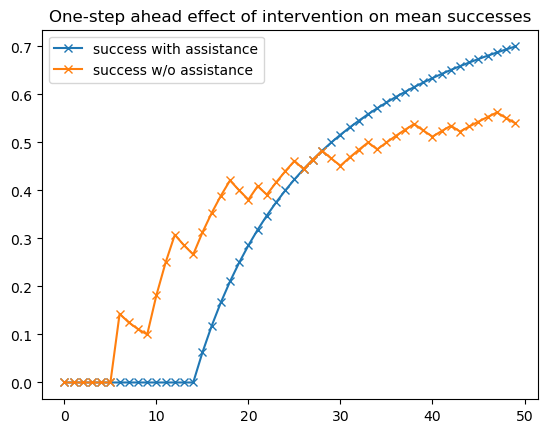

In [353]:
# how do we evaluate the contribution of the assistant?
# how often would the cursor have been outside the target had the camera not moved?
# a. one-step counterfactual: did the intervention make an immediate positive difference
# b. repeated full simulations: how quickly/ consistently does the user hover over target with/ without assistance

# for each step, compute the successor state without assistant intervention
ss_counterfactual = [env.transition_user(s=s, a=a) for s, a in zip(ss[:-1], aa_user)]
hover = np.array([s.hovered_cell for s in ss[1:]])
hover_counterfactual = np.array([s.hovered_cell for s in ss_counterfactual])

plt.subplots()
plt.title('One-step ahead effect of intervention on mean successes')
a = np.cumsum(hover==user.goal)/(1+np.arange(hover.shape[0]))
b = np.cumsum(hover_counterfactual==user.goal)/(1+np.arange(hover.shape[0]))
plt.plot(a, 'x-', label='success with assistance')
plt.plot(b, 'x-', label='success w/o assistance')
plt.legend()

In [354]:
# position of the cursor relative to the center of the target cell
c = env.cells[user.goal]
c = (2*c.xy.x + c.w)/2
c_a = np.array([env._absolute_cursor(s.cursor, s.camera, s.grid_size).x for s in ss[1:]])
c_else = np.array([env._absolute_cursor(s.cursor, s.camera, s.grid_size).x for s in ss_counterfactual])
# wrap-around distance
def wrap_dist(target, x, width):
   return np.minimum(np.abs(x - target), 
                   np.minimum(
                   np.abs(x - width - target), 
                   np.abs(x + width - target)))
d_a = wrap_dist(c, c_a, env.grid_size.w)
d_else = wrap_dist(c, c_else, env.grid_size.w)

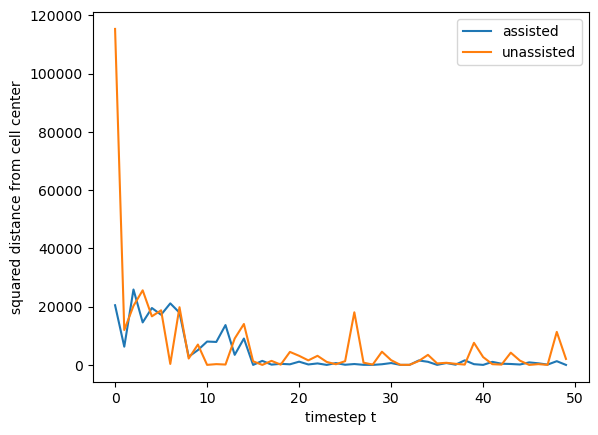

In [358]:
plt.plot(d_a**2, label='assisted')
plt.plot(d_else**2, label='unassisted')
plt.xlabel('timestep t')
plt.ylabel('squared distance from cell center')
plt.legend()